# Preprocessing

* Code by Caroline Juang, c.juang@columbia.edu
* For Machine Learning for the Environmental Sciences, Columbia University
* Professor: Pierre Gentine
* November 2021 - December 2021

### Download Data

Downloading data from box is tricky, here's the URL for the data download.

Data is created by Park Williams, from various sources. [Download from Box](https://ucla.app.box.com/s/epgbcn89365loer1dbp2gz21lc75uut9/folder/136851087076)

Fire data is created by Caroline Juang and Park Williams, from the Monitoring Trends in Burn Severity (MTBS) product and government agency databases. Use the `burnarea_combined.nc` file. [Download from Box](https://ucla.app.box.com/s/epgbcn89365loer1dbp2gz21lc75uut9/folder/136850119129)

### Workspace Setup

**Import variables**

Static
* fractional forest area
* fraction of urban area

Climate
* forest burned area
* daily T_max
* VPD
* RH
* precipitation

**Initial investigations**
* create mask for the western US land
* Monthly and yearly fire return frequency

In [1]:
# import
import numpy as np
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt
import pickle

In [2]:
# importing data string
directory = 'C:\\Users\\carol\\Documents\\Research Data 2020\\12km\\'

### Ecoregions
* 10.1 Cold deserts
* 7.1 Marine west coast forest
* 11.1 Mediterranean California
* 9.4 South Central Semiarid Prairies
* 9.2 Temperate Prairies (not included)
* 13.1 Upper Gila Mountains
* 10.2 Warm Deserts
* 9.3 West-Central Semiarid Prairies
* 6.2 Western Cordillera
* 12.1 Western Sierra Madre Piedmont

In [3]:
## open the ecoregion data
ecoregion_data = xr.open_dataset(directory + 'landcover\\Ecoregions_EPA\\epa_level2.nc')
# drop the bad ecoregion
ecoregion_data = ecoregion_data.sel(province=[0,1,2,3,5,6,7,8,9], drop=True)

ecoregion_legend = ecoregion_data.ecoregion
print(ecoregion_legend.legend)
epa_l2 = ecoregion_data.epa_level2
ecoregion_data = None

1: COLD DESERTS, 2: MARINE WEST COAST FOREST, 3: MEDITERRANEAN CALIFORNIA, 4: SOUTH CENTRAL SEMIARID PRAIRIES, 5: TEMPERATE PRAIRIES, 6: UPPER GILA MOUNTAINS, 7: WARM DESERTS, 8: WEST-CENTRAL SEMIARID PRAIRIES, 9: WESTERN CORDILLERA, 10: WESTERN SIERRA MADRE PIEDMONT


In [4]:
# setup forested area burned

# forest fractional area (Ruefenacht et al., 2018)
forest_type_data = xr.open_dataset(directory + 'landcover\\US_ForestType_Ruefenacht\\forest_type_frac.nc')

# fire burned area (Williams and Juang)
burnarea_data = xr.open_dataset(directory + 'wildfire\\burnarea_combined.nc', engine='netcdf4')
time_str = burnarea_data.time
X = burnarea_data.X
Y = burnarea_data.Y
burnarea_data = burnarea_data.rio.set_spatial_dims(x_dim='X', y_dim='Y', inplace=True)
burn = burnarea_data.burnarea

# get forest burned area (forest fraction x burned area)

# storage
forest = np.zeros((len(Y), len(X)), np.single)
# add up the forest percentages for each forest type
forest = forest_type_data.sum(dim='ftype').forest_type_frac
burnarea = burn*forest.values # result

# constrain time to 2019 (last year of fully-known data)
burnarea = burnarea.loc["1984-01-15":"2019-12-15"]

In [5]:
# import and setup other data

# CLIMATE

ea = xr.open_dataset(directory + 'climate\\primary\\ea.nc')
es = xr.open_dataset(directory + 'climate\\primary\\es.nc')
vpd = es.es - ea.es

rh = xr.open_dataset(directory + 'climate\\primary\\rh.nc')
rh = rh.rh

tmax = xr.open_dataset(directory + 'climate\\primary\\tmax.nc')
tmax = tmax.tmax




<xarray.Dataset>
Dimensions:  (X: 155, Y: 208, time: 1449)
Coordinates:
  * X        (X) float64 -2.349e+06 -2.337e+06 ... -5.132e+05 -5.012e+05
  * Y        (Y) float64 3.166e+06 3.154e+06 3.142e+06 ... 6.945e+05 6.825e+05
  * time     (time) datetime64[ns] 1901-01-15 1901-02-15 ... 2021-09-15
Data variables:
    tmax     (time, Y, X) float32 ...

# Initial investigations

Some interesting ways to look at fire return rate

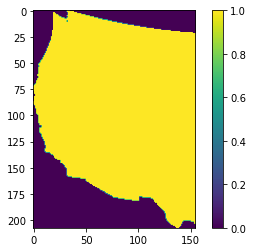

In [4]:
# storage
time = burnarea.time
X = burnarea_data.X
Y = burnarea_data.Y

# get the NaN values in a mask
maskUS = ~np.isnan(burnarea.isel(time=0))
fig, ax = plt.subplots()
this = ax.imshow(maskUS)
fig.colorbar(this)

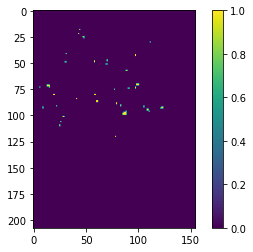

In [5]:
burnyes_month = (burnarea>0).astype(int)

fig, ax = plt.subplots()
this = ax.imshow(burnyes_month.sel(time="2018-09-15"))
fig.colorbar(this)

In [84]:
burnyes_month.where((burnyes_month!=1) & (burnyes_month!=0)).count()

<xarray.DataArray 'burnarea' ()>
array(0)

In [31]:
# burnno_yr captures conditionally whether a gridcell burned. 
# 1 = gricell did not burn
# 0 = gricell burned
burnno_yr = burnarea.resample(indexer={'time':'Y'}).sum(skipna=True)
burnno_yr = (burnno_yr==0).astype(int)

# extract dimension info
time = burnno_yr.time
X = burnno_yr.X
Y = burnno_yr.Y

# initialize storage
return_years = np.zeros((len(time), len(Y), len(X))) # empty storage for years since the last fire

# iterate
index = 1
for year in burnno_yr.time[index:]:
    tmp_thisyr = burnno_yr.isel(time=index) # 2d DataArray
    tmp_prevyr = return_years[index-1] # last year's burn info
    tmp_return = tmp_thisyr + tmp_prevyr # add new year
    tmp_return = tmp_return.where(tmp_thisyr>0, other=0) # if a fire burned, reset the counter with 0
    return_years[index] = tmp_return # store this memory
    index+=1

# transform return_years into a xarray DataArray
return_years = xr.DataArray(data=return_years,
                            dims=['time','Y','X'],
                            coords=dict(X=X, Y=Y, time=time),
                            attrs=dict(
                                description='Time since gridcell last burned',
                                units='years'
                            ))
return_years = return_years.where(maskUS) # put NaN outside western US border

Text(0, 0.5, 'Number of gridcells')

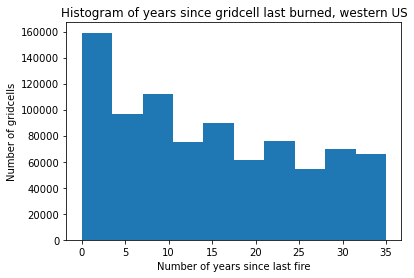

In [41]:
fig, ax = plt.subplots()
ax.hist(np.ndarray.flatten(return_years.values))
ax.set_title('Histogram of years since gridcell last burned, western US')
ax.set_xlabel('Number of years since last fire')
ax.set_ylabel('Number of gridcells')

In [38]:
# burnno_mo captures conditionally how many months since the last time the gridcell burned.
# 1 = gricell did not burn
# 0 = gricell burned
burnno_mo = (burnarea==0).astype(int)

# extract dimension info
time = burnno_mo.time
X = burnno_mo.X
Y = burnno_mo.Y

# initialize storage
return_months = np.zeros((len(time), len(Y), len(X))) # empty storage for years since the last fire

# iterate
index = 1
for year in burnno_mo.time[index:]:
    tmp_thismo = burnno_mo.isel(time=index) # 2d DataArray
    tmp_prevmo = return_months[index-1] # last year's burn info
    tmp_return = tmp_thismo + tmp_prevmo # add new year
    tmp_return = tmp_return.where(tmp_thisyr>0, other=0) # if a fire burned, reset the counter with 0
    return_months[index] = tmp_return # store this memory
    index+=1

# transform into a xarray DataArray
return_months = xr.DataArray(data=return_months,
                            dims=['time','Y','X'],
                            coords=dict(X=X, Y=Y, time=time),
                            attrs=dict(
                                description='Time since gridcell last burned',
                                units='months'
                            ))
return_months = return_months.where(maskUS) # put NaN outside western US border

Text(0, 0.5, 'Number of gridcells')

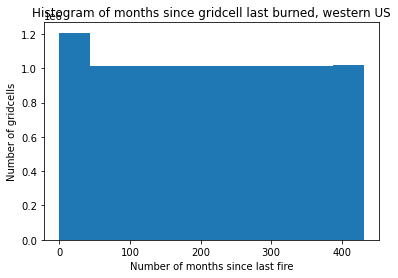

In [43]:
fig, ax = plt.subplots()
ax.hist(np.ndarray.flatten(return_months.values))
ax.set_title('Histogram of months since gridcell last burned, western US')
ax.set_xlabel('Number of months since last fire')
ax.set_ylabel('Number of gridcells')

### Import Dependencies

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from Seq2Seq import Seq2Seq
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox
import matplotlib.pyplot as plt
from ConvLSTM import ConvLSTM
from tqdm.notebook import tqdm
entire_sequence_version=True



# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Import Data and Create Dataloaders

In [4]:
# Load Data as Numpy Array
MovingMNIST = np.load('mnist_test_seq.npy').transpose(1, 0, 2, 3)

# Shuffle Data
np.random.shuffle(MovingMNIST)

# Train, Test, Validation splits
train_data = MovingMNIST[:8000]         
val_data = MovingMNIST[8000:9000]       
test_data = MovingMNIST[9000:10000]     

def collate3d(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # the output is the input sequence shift right by 1, both have length 19
    rand = np.random.randint(10,20)
    seq_len=batch.shape[2]
    return batch[:,:,0:seq_len-1], batch[:,:,1:seq_len]      

def collate2d(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20)                     
    return batch[:,:,rand-10:rand], batch[:,:,rand]

if entire_sequence_version:
    # Training Data Loader
    train_loader = DataLoader(train_data, shuffle=True, 
                            batch_size=16, collate_fn=collate3d)

    # Validation Data Loader
    val_loader = DataLoader(val_data, shuffle=True, 
                            batch_size=16, collate_fn=collate3d)
else:
    # Training Data Loader
    train_loader = DataLoader(train_data, shuffle=True, 
                            batch_size=16, collate_fn=collate2d)

    # Validation Data Loader
    val_loader = DataLoader(val_data, shuffle=True, 
                            batch_size=16, collate_fn=collate2d)

### Visualize Data

In [5]:
# Get a batch
input, _ = next(iter(val_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

### Instantiate Model, Optimizer and Loss

In [6]:
# The input video frames are grayscale, thus single channel
if entire_sequence_version:
    model = Seq2Seq(num_channels=1, num_kernels=64, 
    kernel_size=(3, 3), padding=(1, 1), activation="relu", 
    frame_size=(64, 64), num_layers=3, return_sequences=True).to(device)
else:
    model = Seq2Seq(num_channels=1, num_kernels=64, 
    kernel_size=(3, 3), padding=(1, 1), activation="relu", 
    frame_size=(64, 64), num_layers=3, return_sequences=False).to(device)
    

optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')

### Train for about 20 epochs

In [ ]:
num_epochs = 20

for epoch in range(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(tqdm(train_loader)):
        output = model(input)                                     
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()                                 
    train_loss /= len(train_loader.dataset)                       

    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(val_loader.dataset)                            

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))


Epoch:1 Training Loss:2236.41 Validation Loss:2138.27




Epoch:2 Training Loss:2093.28 Validation Loss:2056.14



### Visualize what our model has learned so far

In [9]:
### for 3d evaluation only 
if entire_sequence_version:
    def collate_test(batch):

        # Last 10 frames are target
        target = np.array(batch)[:,10:]                     

        # Add channel dim, scale pixels between 0 and 1, send to GPU
        batch = torch.tensor(batch).unsqueeze(1)          
        batch = batch / 255.0                             
        batch = batch.to(device)                          
        return batch, target

    # Test Data Loader
    test_loader = DataLoader(test_data,shuffle=True, 
                             batch_size=3, collate_fn=collate_test)

    # Get a batch
    batch, target = next(iter(test_loader))

    # Initialize output sequence
    output = np.zeros(target.shape, dtype=np.uint8)

    # Loop over timesteps
    for timestep in range(target.shape[1]):
      input = batch[:,:,timestep:timestep+10]   
      output[:,timestep]=(model(input).squeeze(1).cpu()[:,-1]>0.5)*255.0

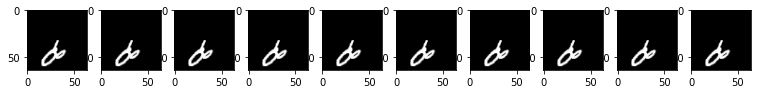

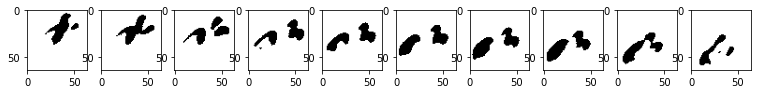

In [52]:
### for 3D evaluation only
if entire_sequence_version:
    seq_len=input.squeeze(1)[0].shape[0]
    fig, axs=plt.subplots(1,10, figsize=(13,1.1))
    ax=axs.flatten()
    for i in range(seq_len):
        ax[i].imshow(input.squeeze(1)[0][1].cpu().numpy() * 255, cmap='gray', vmin=0, vmax=255)

    seq_len=output[0].shape[0]
    fig, axs=plt.subplots(1,10, figsize=(13,1.1))
    ax=axs.flatten()
    for i in range(seq_len):
        ax[i].imshow(output[0][i], cmap='gray', vmin=0, vmax=255)

In [ ]:
### for 2d evaluation
if not entire_sequence_version:
    def collate_test(batch):

        # Last 10 frames are target
        target = np.array(batch)[:,10:]                     

        # Add channel dim, scale pixels between 0 and 1, send to GPU
        batch = torch.tensor(batch).unsqueeze(1)          
        batch = batch / 255.0                             
        batch = batch.to(device)                          
        return batch, target

    # Test Data Loader
    test_loader = DataLoader(test_data,shuffle=True, 
                             batch_size=3, collate_fn=collate_test)

    # Get a batch
    batch, target = next(iter(test_loader))

    # Initialize output sequence
    output = np.zeros(target.shape, dtype=np.uint8)

    # Loop over timesteps
    for timestep in range(target.shape[1]):
      input = batch[:,:,timestep:timestep+10]   
      output[:,timestep]=(model(input).squeeze(1).cpu()>0.5)*255.0

In [10]:
### for 2d evaluation
if not entire_sequence_version:
    for tgt, out in zip(target, output):       # Loop over samples

        # Write target video as gif
        with io.BytesIO() as gif:
            imageio.mimsave(gif, tgt, "GIF", fps = 5)    
            target_gif = gif.getvalue()

        # Write output video as gif
        with io.BytesIO() as gif:
            imageio.mimsave(gif, out, "GIF", fps = 5)    
            output_gif = gif.getvalue()

        display(HBox([widgets.Image(value=target_gif), 
                      widgets.Image(value=output_gif)]))